###RNNs

#Recurrent Neural Networks (RNNs) still take in some input x and output some y, but they also feed some of the output of the network back into itself. This may be done over and over, so that with text input, the network has some memory of words that came much earlier in a sequence.

#How do recurrent neural networks (RNNs) differ from the network architectures you’ve been working with previously?

#RNNs utilise or store information regarding previous inputs to better understand sequences.

"""
Simple RNNs are not always enough when working with text data. Longer sequences, such as a paragraph, often are difficult to handle, as the simple RNN structure loses information about previous inputs fairly quickly.

Long Short-Term Memory models, or LSTMs, help resolve this by keeping a “cell state” across time. These include a “forget gate”, where the cell can choose whether to keep or forget certain words to carry forward in the sequence.

Another interesting aspect of LSTMs is that they can be bidirectional, meaning that information can be passed both forward (later in the text sequence) and backward (earlier in the text sequence).
"""

#Constructing LSTMs in Code

"""
The code for an LSTM layer itself is just the LSTM layer from tf.keras.layers, with the number of LSTM cells to use. However, this is typically wrapped within a Bidirectional layer to make use of passing information both forward and backward in the network, as we noted on the previous page.

# A bidirectional LSTM layer with 64 nodes
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
One thing to note when using a Bidirectional layer is when you look at the model summary, if you put in 64 LSTM nodes, you will actually see a layer shape with 128 nodes (64x2).
"""

"""
#No Need to Flatten
Unlike our more vanilla neural networks in the last lesson, you no longer need to use Flatten or GlobalAveragePooling1D after the LSTM layer - the LSTM can take the output of an Embedding layer and directly hook up to a fully-connected Dense layer with its own output.
"""

"""
#Doubling Up
You can also feed an LSTM layer into another LSTM layer. To do so, on top of just stacking them in order when you create the model, you also need to set return_sequences to True for the earlier LSTM layer - otherwise, as noted above, the output will be ready for fully-connected layers and not be in the sequence format the LSTM layer expects.

# Two bidirectional LSTM layers with 64 nodes each
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64), return_sequences=True)
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
"""

In [2]:
#Constructing LSTMs in Code

#Using LSTMs with Subwords

In [6]:
###NOT TO BE USED###

#import
import pandas as pd

path = tf.keras.utils.get_file('reviews.csv', 
                               'https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P')
print (path)

# Read the csv file
dataset = pd.read_csv(path)

# Review the first few entries in the dataset
dataset.head()

,Unnamed: 0,text,sentiment
0,0,So there is no way for me to plug it in here i...,0
1,1,Good case Excellent value.,1
2,2,Great for the jawbone.,1
3,3,Tied to charger for conversations lasting more...,0
4,4,The mic is great.,1


In [3]:
###Using LSTMs with the subwords dataset

"""
In this colab, you'll compare the results of using a model with an Embedding layer and then adding bidirectional LSTM layers.

You'll work with the dataset of subwords for the combined Yelp and Amazon reviews.

You'll use your models to predict the sentiment of new reviews.
"""

import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [36]:
"""
Get the dataset
Start by getting the dataset containing Amazon and Yelp reviews, with their related sentiment (1 for positive, 0 for negative). 
"""

import pandas as pd

dataset = pd.read_csv('C:/Users/fortn/anaconda3/combined_data.csv')

# Just extract out sentences and labels first - we will create subwords here
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

In [37]:
# Print some example sentences and labels
for x in range(2):
  print(sentences[x])
  print(labels[x])
  print("\n")

So there is no way for me to plug it in here in the US unless I go by a converter.
0


Good case Excellent value.
1




"""
Create a subwords dataset
We will use the Amazon and Yelp reviews dataset with tensorflow_datasets's SubwordTextEncoder functionality.

SubwordTextEncoder.build_from_corpus() will create a tokenizer for us. You could also use this functionality to get subwords from a much larger corpus of text as well, but we'll just use our existing dataset here.

We'll create a subword vocab_size of only the 1,000 most common subwords, as well as cutting off each subword to be at most 5 characters.
"""

In [9]:
import tensorflow_datasets as tfds

vocab_size = 1000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length=5)

# How big is the vocab size?
print("Vocab size is ", tokenizer.vocab_size)

Vocab size is  999


In [10]:
# Check that the tokenizer works appropriately
num = 5
print(sentences[num])
encoded = tokenizer.encode(sentences[num])
print(encoded)

I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


In [11]:
# Separately print out each subword, decoded
for i in encoded:
  print(tokenizer.decode([i]))

I 
have 
to 
j
ig
gl
e 
the 
pl
ug
 
to 
get 
it 
to 
li
ne 
up 
right
 
to 
get 
dec
ent 
vo
lu
me
.


In [ ]:
"""
Replace sentence data with encoded subwords
Now, we'll create the sequences to be used for training by actually encoding each of the individual sentences. This is equivalent to text_to_sequences with the Tokenizer we used in earlier exercises.
"""

In [12]:
for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

In [13]:
# Check the sentences are appropriately replaced
print(sentences[5])

[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


In [17]:
"""
Final pre-processing
Before training, we still need to pad the sequences, as well as split into training and test sets.
"""

import numpy as np

max_length = 50
trunc_type='post'
padding_type='post'

# Pad all sequences
sequences_padded = pad_sequences(sentences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sequences = sequences_padded[0:training_size]
testing_sequences = sequences_padded[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [18]:
###Create the model using an Embedding

embedding_dim = 16

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(), 
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


In [19]:
###Train the model

num_epochs = 30
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(training_sequences, training_labels_final, epochs=num_epochs, validation_data=(testing_sequences, testing_labels_final))

Epoch 1/30
50/50 [==============================] - 5s 24ms/step - loss: 0.6931 - accuracy: 0.4966 - val_loss: 0.6928 - val_accuracy: 0.5013
Epoch 2/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6904 - accuracy: 0.5865 - val_loss: 0.6871 - val_accuracy: 0.6566
Epoch 3/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6838 - accuracy: 0.7182 - val_loss: 0.6790 - val_accuracy: 0.7293
Epoch 4/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6725 - accuracy: 0.7075 - val_loss: 0.6670 - val_accuracy: 0.7393
Epoch 5/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.7822 - val_loss: 0.6489 - val_accuracy: 0.7444
Epoch 6/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.7729 - val_loss: 0.6289 - val_accuracy: 0.7519
Epoch 7/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6062 - accuracy: 0.8069 - val_loss: 0.6084 - val_accuracy: 0.7644
Epoch 8/30
50/50 [=

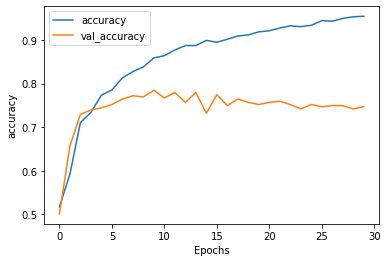

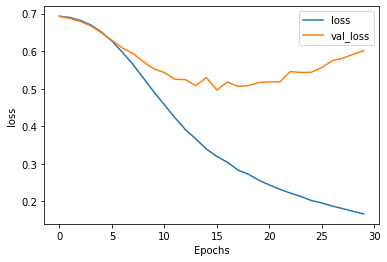

In [20]:
###Plot the accuracy and loss

import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [21]:
"""
Define a function to predict the sentiment of reviews
We'll be creating models with some differences and will use each model to predict the sentiment of some new reviews.

To save time, create a function that will take in a model and some new reviews, and print out the sentiment of each reviews.

The higher the sentiment value is to 1, the more positive the review is.
"""

# Define a function to take a series of reviews
# and predict whether each one is a positive or negative review

# max_length = 100 # previously defined

def predict_review(model, new_sentences, maxlen=max_length, show_padded_sequence=True ):
  # Keep the original sentences so that we can keep using them later
  # Create an array to hold the encoded sequences
  new_sequences = []

  # Convert the new reviews to sequences
  for i, frvw in enumerate(new_sentences):
    new_sequences.append(tokenizer.encode(frvw))

  trunc_type='post' 
  padding_type='post'

  # Pad all sequences for the new reviews
  new_reviews_padded = pad_sequences(new_sequences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)             

  classes = model.predict(new_reviews_padded)

  # The closer the class is to 1, the more positive the review is
  for x in range(len(new_sentences)):
    
    # We can see the padded sequence if desired
    # Print the sequence
    if (show_padded_sequence):
      print(new_reviews_padded[x])
    # Print the review as text
    print(new_sentences[x])
    # Print its predicted class
    print(classes[x])
    print("\n")

In [22]:
# Use the model to predict some reviews   
fake_reviews = ["I love this phone", 
                "Everything was cold",
                "Everything was hot exactly as I wanted", 
                "Everything was green", 
                "the host seated us immediately",
                "they gave us free chocolate cake", 
                "we couldn't hear each other talk because of the shouting in the kitchen"
              ]

predict_review(model, fake_reviews)

[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.8961266]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.08416119]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.31972966]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.09132406]


[  1 109 228 540 237 635 24

In [23]:
"""
Define a function to train and show the results of models with different layers
In the rest of this colab, we will define models, and then see the results.

Define a function that will take the model, compile it, train it, graph the accuracy and loss, and then predict some results.
"""

def fit_model_now (model, sentences) :
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.summary()
  history = model.fit(training_sequences, training_labels_final, epochs=num_epochs, 
                      validation_data=(testing_sequences, testing_labels_final))
  return history

def plot_results (history):
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")

def fit_model_and_show_results (model, sentences):
  history = fit_model_now(model, sentences)
  plot_results(history)
  predict_review(model, sentences)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                4224      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 20,429
Trainable params: 20,429
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
50/50 [==============================] - 10s 60ms/step - loss: 0.6921 - accuracy: 0.5286 - val_loss: 0.6916 - val_accuracy: 0.4737
Epoch 2/30
50/50 [==============================] - 1s 29ms/step - loss: 0.6603 - accuracy: 0.6483 - val_l

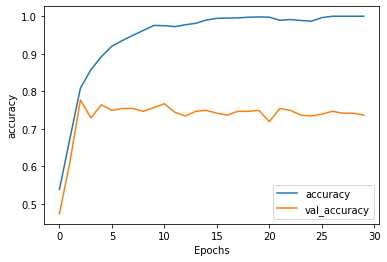

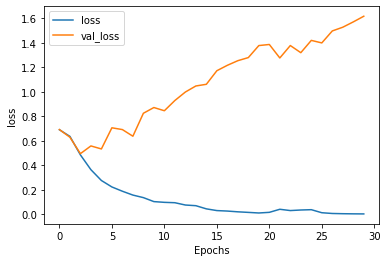

[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.9974514]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.0002504]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.7397736]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.00764859]


[  1 109 228 540 237 635 241 

In [24]:
"""
Add a bidirectional LSTM
Create a new model that uses a bidirectional LSTM.

Then use the function we have already defined to compile the model, train it, graph the accuracy and loss, then predict some results.
"""

# Define the model
model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)), 
    tf.keras.layers.Dense(6, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile and train the model and then show the predictions for our extra sentences
fit_model_and_show_results(model_bidi_lstm, fake_reviews)


In [ ]:
"""
Compare predictions for all the models
It can be hard to see which model gives a better prediction for different reviews when you examine each model separately. So for comparison purposes, here we define some more reviews and print out the predictions that each of the three models gives for each review:

Embeddings and a Global Average Pooling layer
Embeddings and a Bidirectional LSTM layer
Embeddings and two Bidirectional LSTM layers
The results are not always what you might expect. The input dataset is fairly small, it has less than 2000 reviews. Some of the reviews are fairly short, and some of the short ones are fairly repetitive which reduces their impact on improving the model, such as these two reviews:

Bad Quality.
Low Quality.
Feel free to add more reviews of your own, or change the reviews. The results will depend on the combination of words in the reviews, and how well they match to reviews in the training set.
"""

In [25]:
my_reviews =["lovely", "dreadful", "stay away",
             "everything was hot exactly as I wanted",
             "everything was not exactly as I wanted",
             "they gave us free chocolate cake",
             "I've never eaten anything so spicy in my life, my throat burned for hours",
             "for a phone that is as expensive as this one I expect it to be much easier to use than this thing is",
             "we left there very full for a low price so I'd say you just can't go wrong at this place",
             "that place does not have quality meals and it isn't a good place to go for dinner",
             ]

In [26]:
print("===================================\n","Embeddings only:\n", "===================================",)
predict_review(model, my_reviews, show_padded_sequence=False)

 Embeddings only:
lovely
[0.92551625]


dreadful
[0.25834972]


stay away
[0.61609364]


everything was hot exactly as I wanted
[0.74045444]


everything was not exactly as I wanted
[0.4779954]


they gave us free chocolate cake
[0.6989794]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.01529682]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.64953727]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.7241044]


that place does not have quality meals and it isn't a good place to go for dinner
[0.8264574]




In [27]:
print("===================================\n", "With a single bidirectional LSTM:\n", "===================================")
predict_review(model_bidi_lstm, my_reviews, show_padded_sequence=False)

 With a single bidirectional LSTM:
lovely
[0.97579813]


dreadful
[0.00201425]


stay away
[0.13684458]


everything was hot exactly as I wanted
[0.99352866]


everything was not exactly as I wanted
[0.35134333]


they gave us free chocolate cake
[0.98202884]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.99731624]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.96400094]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.97615784]


that place does not have quality meals and it isn't a good place to go for dinner
[0.968276]




In [29]:
print("===================================\n","With two bidirectional LSTMs:\n", "===================================")
predict_review(model_multiple_bidi_lstm, my_reviews, show_padded_sequence=False)

 With two bidirectional LSTMs:


NameError: name 'model_multiple_bidi_lstm' is not defined